## This is my attempt at implementing the RouBl algorithm

In [117]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [118]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullCovGaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, prior_std=[0.1,0.1], alpha=0.1, gamma=1,
                 sqrt_width_scaling=False, device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()

        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]
        self.alpha = alpha
        self.gamma = gamma
        n = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))
        self.num_params = n

        # define the prior parameters
        # prior_mean = torch.randn(n, **factory_kwargs) * prior_std[0]
        prior_mean = torch.zeros(n)
        # prior_cov_chol =  torch.eye(n, **factory_kwargs) * prior_std[1] + torch.tril(torch.randn(n,n) * prior_std[1], diagonal=-1)
        prior_cov_chol = torch.eye(n, **factory_kwargs) * prior_std[1]

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', prior_mean)
        self.register_buffer('prior_cov_chol', prior_cov_chol)
        self.register_buffer('prior_cov_inv', torch.linalg.inv(prior_cov_chol @ prior_cov_chol.t()))

        # initialise the trainable variational parameters for q distribution, setting them equal to the prior
        self.mean = prior_mean
        self.cov_chol = prior_cov_chol
        # self.cov_chol = torch.diag(prior_std*torch.ones(n, **factory_kwargs))

        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ cov_chol_inv.t() @ self.mean

    # I don't know what this is doing
    # def reset_parameters(self, init_std=0.5):
    #     nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
    #     bound = self.dim_in ** -0.5
    #     nn.init.uniform_(self.bias_mean, -bound, bound)
    #     _init_std_param = math.log(math.expm1(init_std))
    #     self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
    #     self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator#
   
    # @property
    # def scale_tril(self):
    #     # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
    #     # Only taking values below the main diagonal? no it takes everything below diagonal
    #     return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)


    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl

    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input

# Example usage
net = FullCovGaussianNetwork([1, 2, 1], prior_std=[0.1, 0.1])
input_data = torch.tensor(([1.0], [1.5]), requires_grad=False)
targets = torch.tensor(([2.0], [2.1]), requires_grad=False)


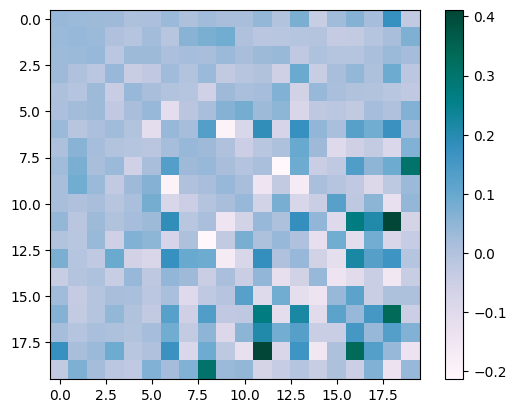

In [119]:
factory_kwargs = {'device': None, 'dtype': None}
n = 20
prior_std=[0.1, 0.2]

prior_mean = torch.randn(n, **factory_kwargs) * prior_std[0]
prior_cov_chol =  torch.tril(torch.randn(n,n) * prior_std[1])

# print(prior_cov_chol)
# print((prior_cov_chol @ prior_cov_chol.t()))

prior_cov = prior_cov_chol @ prior_cov_chol.t()
for i in range(n):
    prior_cov[i,i] = prior_std[1]**2

def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

a = to_numpy(prior_cov)

plt.imshow(a, cmap='PuBuGn')
plt.colorbar()
plt.show()

In [120]:
factory_kwargs = {'device': None, 'dtype': None}
n = 5
prior_std=[0.1, 0.2]

torch.eye(n, **factory_kwargs) * prior_std[1]

tensor([[0.2000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2000]])

In [121]:
A = torch.randn(n, n) * prior_std[1]
M = (A + A.T) / 2  # Symmetric
M += n * torch.eye(n)  # Positive definite



### Regression Ground Truth & Dataset

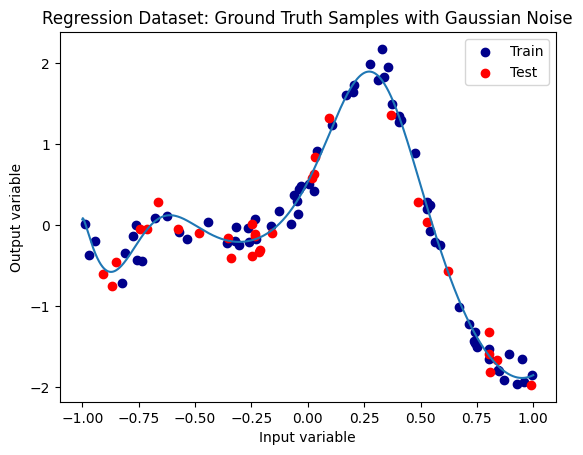

In [122]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

def generate_dataset(size=100, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)


xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
x_tr, x_te, y_tr, y_te = generate_dataset()

plt.title("Regression Dataset: Ground Truth Samples with Gaussian Noise")
plt.plot(xs, ys)
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Plot BNN Prior in Function Space

In [123]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 5, 5, 1], prior_std=[0.2,0.3], alpha=1, gamma=0.0001)

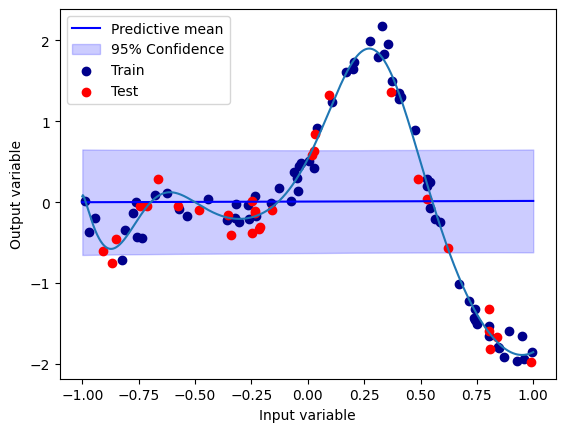

In [124]:
def plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net, n_samples=100):
    n_test = xs.shape[0]
    predictions = np.zeros((n_samples, n_test))

    for i in range(n_samples):
        params_sample = net.sample_params()
        predictions[i,] = to_numpy(net.forward(torch.tensor(xs, dtype=torch.float32).unsqueeze(1), params_sample).flatten())

    pred_mean = predictions.mean(0)
    pred_std = predictions.std(0)

    x_tr, x_te = to_numpy(x_tr).flatten(), to_numpy(x_te).flatten()
    y_tr, y_te = to_numpy(y_tr).flatten(), to_numpy(y_te).flatten()

    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')
    plt.plot(xs, ys)
    plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
    plt.scatter(x_te, y_te, label='Test', color='red')
    plt.xlabel('Input variable')
    plt.ylabel('Output variable')
    plt.legend()
    plt.show()

    
    ############### continue plotting here ###############

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

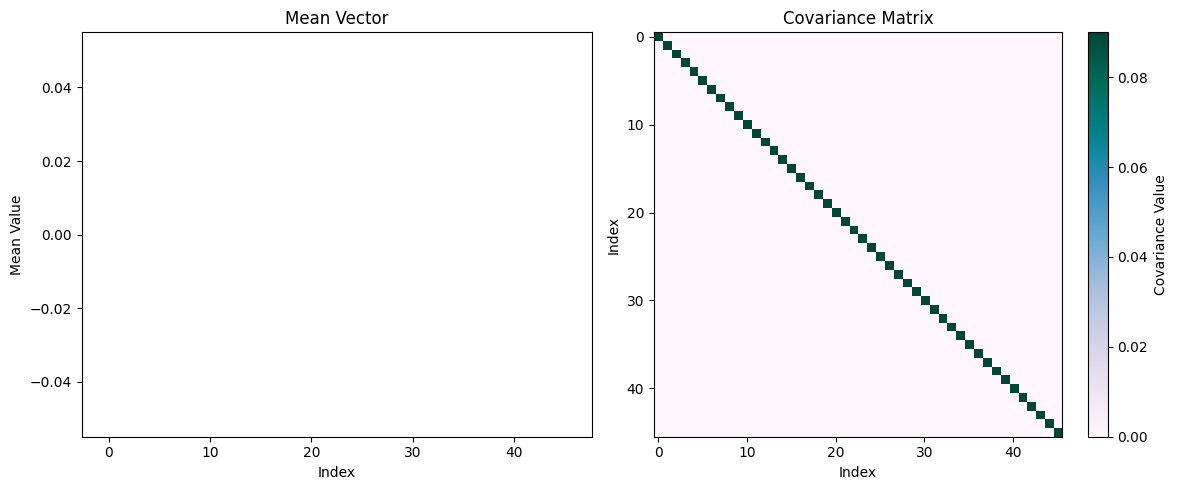

In [125]:
def plot_mean_and_covariance(BNN):
    # Convert mean vector and covariance matrix to NumPy
    mean = to_numpy(BNN.mean)
    cov = to_numpy(BNN.cov_chol @ BNN.cov_chol.t())

    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot mean vector as a bar plot
    axs[0].bar(range(len(mean)), mean, color='steelblue')
    axs[0].set_title("Mean Vector")
    axs[0].set_xlabel("Index")
    axs[0].set_ylabel("Mean Value")

    # Plot covariance matrix as a heatmap
    im = axs[1].imshow(cov, cmap='PuBuGn', aspect='auto')
    axs[1].set_title("Covariance Matrix")
    axs[1].set_xlabel("Index")
    axs[1].set_ylabel("Index")
    fig.colorbar(im, ax=axs[1], label="Covariance Value")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_mean_and_covariance(BNN)


### Training

In [126]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=[0.2,0.3], alpha=0.0001, gamma=1)

In [127]:
def compute_param_gradients(net, input, targets, noise, K=500):
    gradients = torch.zeros(net.num_params, requires_grad=False)
    for _ in range(K):
        sampled_params = net.sample_params()  # Sample from q distribution with gradient tracking
        print('Params', sampled_params)
        if sampled_params.grad is not None:
            sampled_params.grad.zero_()
        output = net.forward(input, sampled_params)  # Forward pass
        print('output:',output)
        for i in range(output.shape[0]):
            output[i].backward(-1/(noise**2) * (targets[i] - output[i]), retain_graph=True)  # Backpropagate to calculate gradients

        net_grads = sampled_params.grad
        g_k = net.gamma * net.prior_cov_inv @ (sampled_params - net.prior_mean) + net_grads
        gradients += g_k

    # print(f'Max gradient is {torch.max(1/K * gradients.unsqueeze(1))}')
    # print('grads',(1/K * gradients.unsqueeze(1)))
    return 1/K * gradients.unsqueeze(1)


# BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=0.1, init_std=0.1, alpha=0.01, gamma=1)
# input_data = torch.tensor(([1.0], [1.5]), requires_grad=True)
# targets = torch.tensor(([2.0], [2.1]), requires_grad=False)

Epoch 1
Params tensor([-0.1281,  0.0379,  0.6007, -0.0450, -0.1120, -0.4631, -0.6078,  0.3223,
         0.0554, -0.0525,  0.1198,  0.4119, -0.2613], requires_grad=True)
output: tensor([[-0.2629],
        [-0.2628],
        [-0.2629],
        [-0.2628],
        [-0.2632],
        [-0.2631],
        [-0.2629],
        [-0.2634],
        [-0.2628],
        [-0.2631],
        [-0.2626],
        [-0.2631],
        [-0.2629],
        [-0.2629],
        [-0.2630],
        [-0.2631],
        [-0.2633],
        [-0.2628],
        [-0.2631],
        [-0.2629],
        [-0.2629],
        [-0.2629],
        [-0.2625],
        [-0.2631],
        [-0.2630],
        [-0.2625],
        [-0.2631],
        [-0.2630],
        [-0.2632],
        [-0.2629],
        [-0.2628],
        [-0.2633],
        [-0.2627],
        [-0.2632],
        [-0.2630],
        [-0.2631],
        [-0.2632],
        [-0.2633],
        [-0.2629],
        [-0.2631],
        [-0.2629],
        [-0.2633],
        [-0.2626],
      

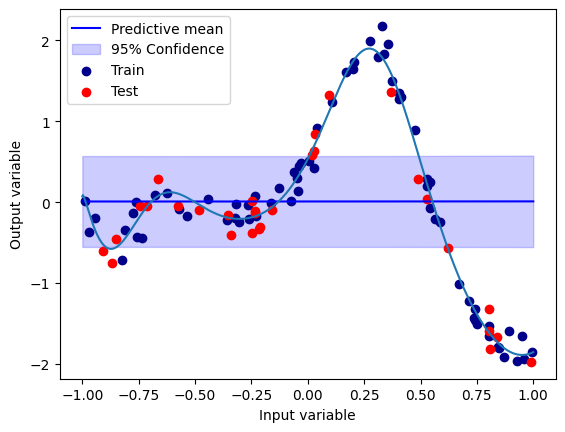

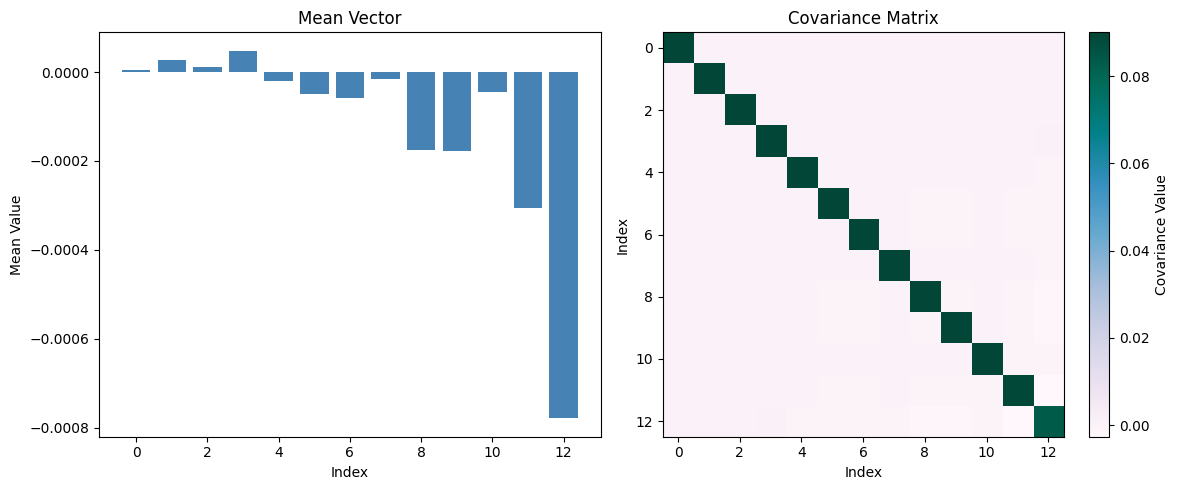

In [128]:
# Using sigma (not its chol), runs into errors computing chol at the end
def update_variational_params(net, input, targets, noise=0.1, K=500):
    n = net.num_params
    g = compute_param_gradients(net, input, targets, noise, K)
    g_tp = g.t()

    with torch.no_grad():
        mu, sigma = net.mean.unsqueeze(1), net.cov_chol @ net.cov_chol.t()
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        
        sigma_tilde = 1 / (1 - alpha*gamma) * sigma
        v = sigma_tilde @ g 
        sigma = sigma_tilde - alpha / (1 + alpha * g_tp @ v) * v @ v.t()
        nu = g_tp @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha * (1 - nu) * g

    net.lambda_1 = lambda_1.flatten()
    net.mean = (sigma @ lambda_1).flatten()
    net.cov_chol = torch.linalg.cholesky(sigma, upper=False)


# Using rank-1 cholesky update algo
def update_variational_params2(net, input, targets, noise, K=100):
    n = net.num_params
    g = compute_param_gradients(net, input, targets, noise, K)
    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)
        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        
        v = alpha_prime * chol @ (chol.t() @ g)

        beta = - alpha / (1 + alpha * g.t() @ v)
        omega = v.detach().clone()
        b = 1 
        chol_new = torch.zeros(n,n)
        for j in range(n):
            chol_new[j,j] = torch.sqrt(alpha_prime * chol[j,j]**2 + beta/b * omega[j]**2)
            xi = alpha_prime * chol[j,j]**2 * b + beta * omega[j]**2
            for k in range(j,n):
                omega[k] = omega[k] - omega[j]/chol[j,j] * torch.sqrt(alpha_prime) * chol[k,j]
                chol_new[k,j] = torch.sqrt(alpha_prime) * chol_new[j,j]/chol[j,j] * chol[k,j] + chol_new[j,j] * beta * omega[j]/xi * omega[k]

            b = b + beta * omega[j]**2/(alpha_prime * chol[j,j]**2)

        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
        
    net.lambda_1 = lambda_1.flatten()
    net.mean = ((chol_new @ chol_new.t())@lambda_1).flatten()
    net.cov_chol = chol_new


# BNN = FullCovGaussianNetwork(layer_sizes=[1, 5, 5, 1], prior_std=[0.1,0.7], alpha=1, gamma=0.1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 1
noise = 0.2

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params(BNN, x_tr, y_tr, noise, K=100)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

plot_mean_and_covariance(BNN)

    


In [129]:
def update_variational_params_choldate(net, input, targets, noise=1, K=100):
    g = compute_param_gradients(net, input, targets, noise, K) # I think this is ok but it's possible it's updating in the wrong direction
    g_tp = g.t()

    with torch.no_grad():
        mu, chol = net.mean.unsqueeze(1), net.cov_chol
        
        alpha, gamma, lambda_1 = net.alpha, net.gamma, net.lambda_1.unsqueeze(1)

        alpha_prime = torch.tensor([1 / (1-alpha*gamma)])
        v = alpha_prime * chol @ (chol.t() @ g) #sigma_tilde @ g

        beta = - alpha / (1 + alpha * g.t() @ v)
        beta = beta.item()
        chol = torch.sqrt(alpha_prime) * chol
        
        chol_tf = tf.convert_to_tensor(chol.numpy())
        v_tf = tf.convert_to_tensor(v.numpy())
        v_tf = tf.reshape(v_tf, [13])  # Shape (13,)

        chol_updated_tf = tfp.math.cholesky_update(chol_tf, v_tf, multiplier=beta)
        chol_updated = torch.from_numpy(chol_updated_tf.numpy())

        
        nu = g.t() @ mu
        lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * g
    net.lambda_1 = lambda_1.flatten()
    net.mean = chol_updated @ (chol_updated.t()@lambda_1).flatten() # might need to be true
    # print(net.mean)
    net.cov_chol = chol_updated # same here


In [131]:
BNN = FullCovGaussianNetwork(layer_sizes=[1, 2, 2, 1], prior_std=[0.2,0.3], alpha=0.01, gamma=1)

Epoch 1
tensor([[-1.8491e+00],
        [ 6.3537e-01],
        [ 1.7326e-01],
        [-3.1888e+00],
        [ 1.8117e-01],
        [-2.7996e-01],
        [ 1.3790e+00],
        [-3.1158e+00],
        [-7.8569e+00],
        [ 8.3155e+01],
        [-1.6913e+01],
        [-9.2180e+01],
        [-4.8140e+02]], grad_fn=<MulBackward0>)
Epoch 2
tensor([[-9.1190e-01],
        [-1.2058e+01],
        [-1.8954e-01],
        [-3.7722e+01],
        [-8.7193e-01],
        [-6.9388e-01],
        [ 1.8541e+00],
        [ 7.8723e+00],
        [-3.5716e+01],
        [ 9.8160e+01],
        [-1.4077e+01],
        [-8.5337e+01],
        [-4.0360e+02]], grad_fn=<MulBackward0>)
Epoch 3
tensor([[ 4.7165e+00],
        [-1.3983e+00],
        [ 6.6358e-01],
        [-3.0226e+00],
        [ 1.5447e+00],
        [-2.4559e+00],
        [ 3.3097e-02],
        [-1.0524e+00],
        [-5.5076e+01],
        [ 3.1790e+01],
        [-1.2404e-01],
        [-6.9024e+01],
        [-4.5569e+02]], grad_fn=<MulBackward0>)
Epoc

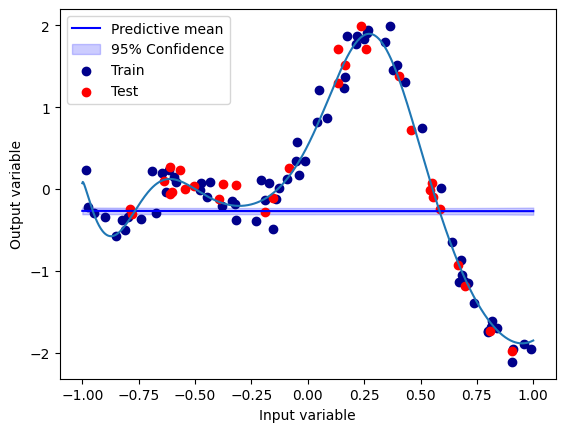

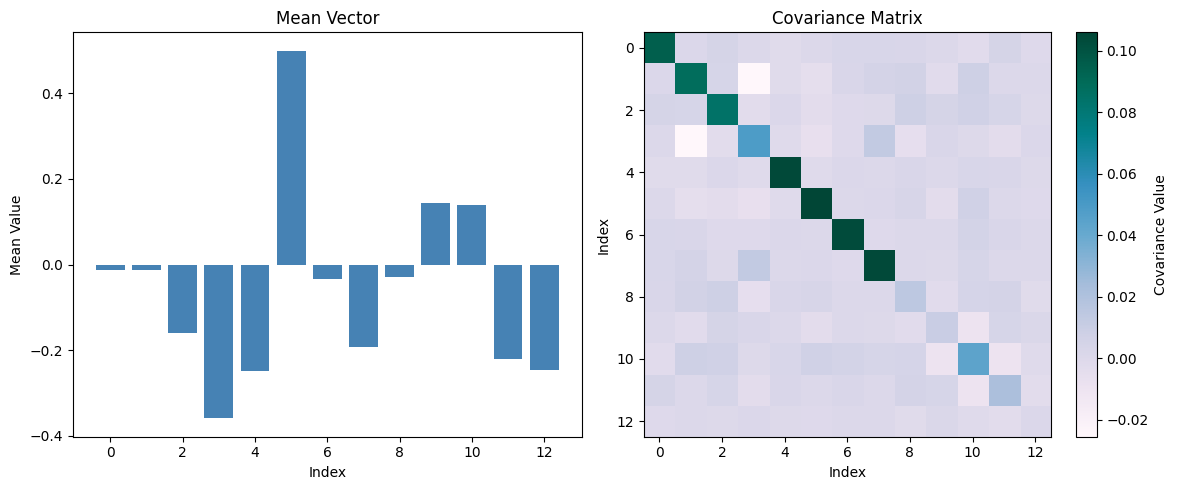

In [81]:

# BNN = FullCovGaussianNetwork(layer_sizes=[1, 5, 5, 1], prior_std=[0.1,0.7], alpha=1, gamma=0.1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
noise = 0.2

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}')
    update_variational_params_choldate(BNN, x_tr, y_tr, noise, K=10)

plot_regression_results(x_tr, x_te, y_tr, y_te, xs, ys, net=BNN, n_samples=100)

plot_mean_and_covariance(BNN)

    


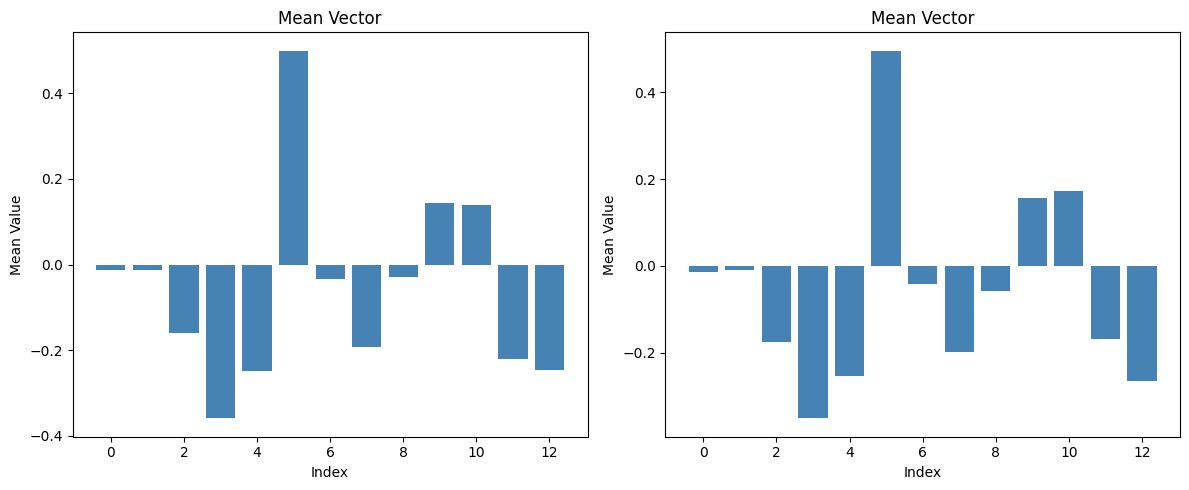

In [88]:
# Convert mean vector and covariance matrix to NumPy
mean = to_numpy(BNN.mean)
prior = to_numpy(BNN.prior_mean)

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean vector as a bar plot
axs[0].bar(range(len(mean)), mean, color='steelblue')
axs[0].set_title("Mean Vector")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Mean Value")

# Plot mean vector as a bar plot
axs[1].bar(range(len(prior)), prior, color='steelblue')
axs[1].set_title("Mean Vector")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Mean Value")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [132]:
input_data = torch.tensor(([1.0]), requires_grad=False)
targets = torch.tensor(([2.0]), requires_grad=False)

In [133]:
compute_param_gradients(BNN, input_data, targets, noise = 0.15, K=1)

Params tensor([ 0.0232,  0.1553, -0.1484, -0.2393,  0.0467, -0.0928,  0.0435, -0.1294,
        -0.3435,  0.2387,  0.2884,  0.0913,  0.4074], requires_grad=True)
output: tensor([0.4283], grad_fn=<ViewBackward0>)


tensor([[  0.2547],
        [  1.7340],
        [ -1.6521],
        [ -2.6502],
        [  0.5193],
        [ -1.0309],
        [  0.4918],
        [ -1.4326],
        [ -4.0184],
        [ -3.7294],
        [  3.4444],
        [-15.6601],
        [-65.3284]], grad_fn=<MulBackward0>)

SyntaxError: closing parenthesis ']' does not match opening parenthesis '{' on line 1 (2093211056.py, line 13)

In [165]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Parameters (13 in total)
params = torch.tensor([ 0.0232,  0.1553, -0.1484, -0.2393,  0.0467, -0.0928,  0.0435, -0.1294,
        -0.3435,  0.2387,  0.2884,  0.0913,  0.4074])

# Neural Network Structure
class CustomNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_weight = nn.Parameter(params[0:2].view(2, 1))  # 2 weights (2x1 matrix)
        self.fc1_bias = nn.Parameter(params[2:4].view(2))       # 2 biases (vector)
        self.fc2_weight = nn.Parameter(params[4:8].view(2, 2))  # 4 weights (2x2 matrix)
        self.fc2_bias = nn.Parameter(params[8:10].view(2))      # 2 biases (vector)
        self.fc3_weight = nn.Parameter(params[10:12].view(1, 2))  # 2 weights (1x2 matrix)
        self.fc3_bias = nn.Parameter(params[12:13].view(1))       # 1 bias (scalar)

    def forward(self, x):
        # First Layer: Leaky ReLU activation
        x = F.linear(x, self.fc1_weight, self.fc1_bias)
        x = F.leaky_relu(x, negative_slope=0.01)
        
        # Second Layer: Leaky ReLU activation
        x = F.linear(x, self.fc2_weight, self.fc2_bias)
        x = F.leaky_relu(x, negative_slope=0.01)
        
        # Third Layer: Leaky ReLU activation
        x = F.linear(x, self.fc3_weight, self.fc3_bias)
        x = F.leaky_relu(x, negative_slope=0.01)
        
        return x

# Initialize and test
model = CustomNN()
# for i in input_data:
#     output = model(i)
#     output.backward() 
    
output = model(input_data)
print("Output:", output)


Output: tensor([0.4282], grad_fn=<LeakyReluBackward0>)


In [166]:
# Forward pass
output = model(input_data)
params = params.unsqueeze(1)

# Backward pass to compute gradients
output.backward()

# Print gradients of model parameters
print("Gradients:")
print("fc1_weight:", model.fc1_weight.grad)
print("fc1_bias:", model.fc1_bias.grad)
print("fc2_weight:", model.fc2_weight.grad)
print("fc2_bias:", model.fc2_bias.grad)
print("fc3_weight:", model.fc3_weight.grad)
print("fc3_bias:", model.fc3_bias.grad)


Gradients:
fc1_weight: tensor([[ 4.1062e-05],
        [-1.2082e-04]])
fc1_bias: tensor([ 4.1062e-05, -1.2082e-04])
fc2_weight: tensor([[-3.6108e-06, -2.4226e-06],
        [-1.1431e-04, -7.6692e-05]])
fc2_bias: tensor([0.0029, 0.0913])
fc3_weight: tensor([[-0.0034,  0.2388]])
fc3_bias: tensor([1.])


In [167]:
df_dw = torch.tensor([[ 4.1062e-05],
        [-1.2082e-04],
        [ 4.1062e-05], [-1.2082e-04],
        [-3.6108e-06],[ -2.4226e-06],
        [-1.1431e-04], [-7.6692e-05],
        [0.0029], [0.0913],
        [-0.0034],  [0.2388],
        [1.]
        ])


In [168]:
g = -df_dw*(-(2-0.4283))/0.15**2 + 1/0.09*torch.eye(13)@params

In [177]:
g

tensor([[ 0.2606],
        [ 1.7171],
        [-1.6460],
        [-2.6673],
        [ 0.5186],
        [-1.0313],
        [ 0.4753],
        [-1.4431],
        [-3.6141],
        [ 9.0298],
        [ 2.9669],
        [17.6954],
        [74.3800]])

In [170]:
my_g = torch.tensor([[  0.2547],
        [  1.7340],
        [ -1.6521],
        [ -2.6502],
        [  0.5193],
        [ -1.0309],
        [  0.4918],
        [ -1.4326],
        [ -4.0184],
        [ -3.7294],
        [  3.4444],
        [-15.6601],
        [-65.3284]])

In [173]:
my_g

tensor([[  0.2547],
        [  1.7340],
        [ -1.6521],
        [ -2.6502],
        [  0.5193],
        [ -1.0309],
        [  0.4918],
        [ -1.4326],
        [ -4.0184],
        [ -3.7294],
        [  3.4444],
        [-15.6601],
        [-65.3284]])

In [172]:
g

tensor([[ 0.2606],
        [ 1.7171],
        [-1.6460],
        [-2.6673],
        [ 0.5186],
        [-1.0313],
        [ 0.4753],
        [-1.4431],
        [-3.6141],
        [ 9.0298],
        [ 2.9669],
        [17.6954],
        [74.3800]])